## News Article Classification

### Problem Statement
The main objective of this project is to develop a classification model that can automatically assign news articles to predefined categories. Using a labeled dataset of news articles, the model will be trained to predict the most appropriate category (such as sports, politics, or technology) for any given article.

In [1]:
## Importing the libraries which will be usefull for our analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ermoh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ermoh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ermoh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### 1. Data Collection and Preprocessing

In [2]:
## Loading dataset
df = pd.read_csv("data_news.csv")

In [3]:
## Display basic info about the dataset
df.info()
df.head()
df['category'].value_counts()  # Check distribution of categories (e.g., WELLNESS, SPORTS)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   category           50000 non-null  object
 1   headline           50000 non-null  object
 2   links              50000 non-null  object
 3   short_description  50000 non-null  object
 4   keywords           47332 non-null  object
dtypes: object(5)
memory usage: 1.9+ MB


category
WELLNESS          5000
POLITICS          5000
ENTERTAINMENT     5000
TRAVEL            5000
STYLE & BEAUTY    5000
PARENTING         5000
FOOD & DRINK      5000
WORLD NEWS        5000
BUSINESS          5000
SPORTS            5000
Name: count, dtype: int64

In [4]:
## Handle missing data: Drop rows with missing 'short_description' or 'category'
df = df.dropna(subset=['short_description', 'category'])

In [5]:
## Clean and preprocess the text data
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Remove special characters, punctuation, and convert to lowercase
    text = re.sub(r'[^a-zA-Z\s]', '', text.lower())
    # Tokenization
    tokens = word_tokenize(text)      # Split text into words (tokens)
    # Remove stop words and lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

## Apply preprocessing to the 'short_description' column (assuming this is the main text for classification)
df['processed_text'] = df['short_description'].apply(preprocess_text)

### 2. Feature Extraction and EDA

In [6]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer

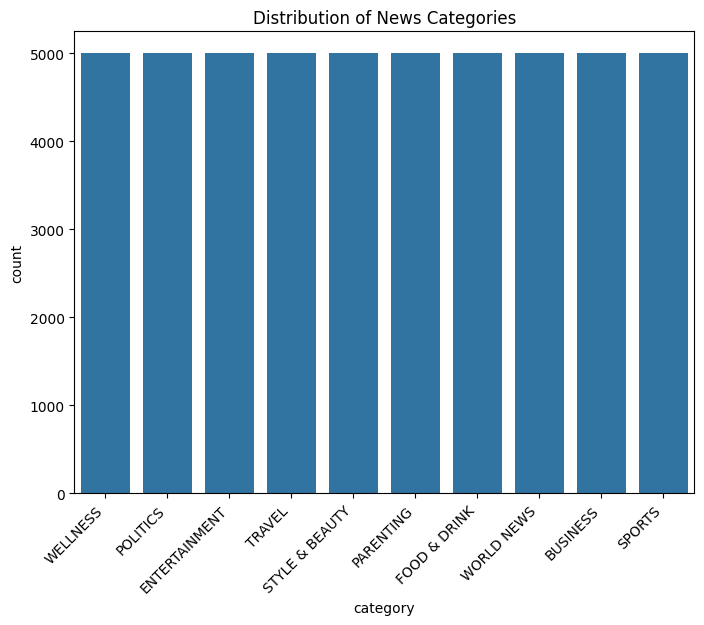

In [7]:
## Perform EDA: Visualize category distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='category', data=df)
plt.xticks(rotation=45, ha='right')     # 'ha' for horizontal alignment can be useful with rotation
plt.title('Distribution of News Categories')
plt.show()

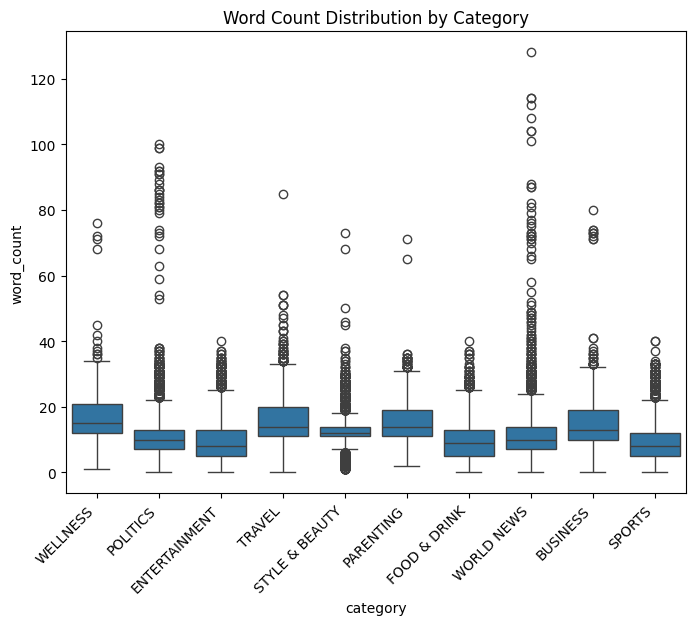

In [8]:
## Additional textual features (e.g., word count)
df['word_count'] = df['processed_text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(8, 6))
sns.boxplot(x='category', y='word_count', data=df)
plt.xticks(rotation=45, ha='right')
plt.title('Word Count Distribution by Category')
plt.show()

In [9]:
## Feature extraction using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))

## Split data into train and test sets
X = df['processed_text']
y = df['category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Fit TF-IDF on training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

### 3. Model Development and Training

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

In [11]:
## Defining models to experiment with
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Naive Bayes': MultinomialNB(),
    'SVM': SVC(kernel='linear')
}

In [12]:
## Training and evaluating each model using cross-validation
best_model = None
best_score = 0
for name, model in models.items():
    # Create a pipeline for simplicity
    pipeline = Pipeline([
        ('tfidf', tfidf_vectorizer),
        ('classifier', model)
    ])
    # Cross-validation
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='f1_macro')  # Use F1-macro for multi-class
    print(f"{name} CV F1-Score: {cv_scores.mean():.4f}")
    
    # Train on full training data
    pipeline.fit(X_train, y_train)
    
    # Check if this is the best model
    if cv_scores.mean() > best_score:
        best_score = cv_scores.mean()
        best_model = pipeline

Logistic Regression CV F1-Score: 0.6479
Naive Bayes CV F1-Score: 0.6290
SVM CV F1-Score: 0.6346


### 4. Model Evaluation

In [13]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

## Predicting on test set using the best model
y_pred = best_model.predict(X_test)

In [14]:
## Evaluating metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test F1-Score: {f1:.4f}")
print(classification_report(y_test, y_pred))

Test Accuracy: 0.6555
Test F1-Score: 0.6556
                precision    recall  f1-score   support

      BUSINESS       0.63      0.68      0.65       955
 ENTERTAINMENT       0.54      0.56      0.55       985
  FOOD & DRINK       0.70      0.70      0.70      1021
     PARENTING       0.66      0.63      0.65      1030
      POLITICS       0.65      0.60      0.62      1034
        SPORTS       0.67      0.70      0.68       995
STYLE & BEAUTY       0.73      0.69      0.71       986
        TRAVEL       0.71      0.66      0.68      1008
      WELLNESS       0.62      0.67      0.64      1009
    WORLD NEWS       0.66      0.66      0.66       977

      accuracy                           0.66     10000
     macro avg       0.66      0.66      0.66     10000
  weighted avg       0.66      0.66      0.66     10000



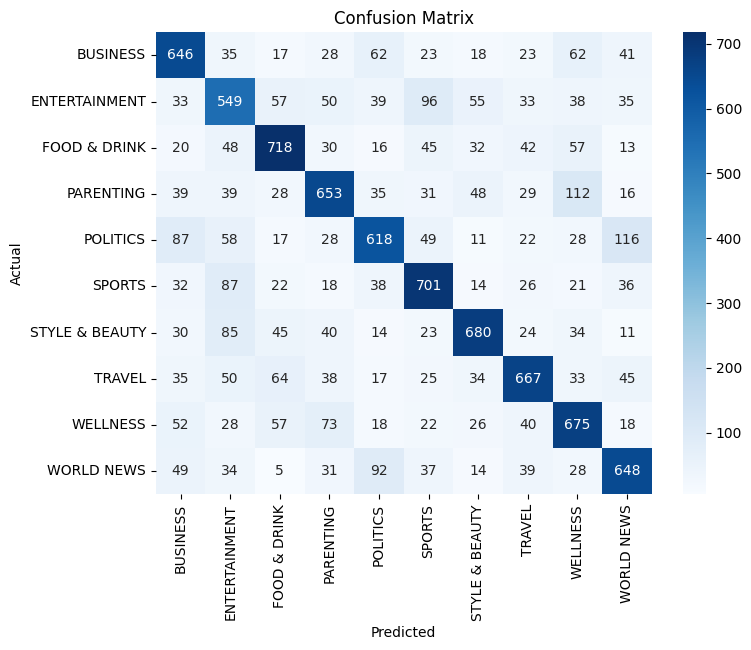

In [15]:
## Confusion matrix visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### 5. Final Report and Presentation

In [16]:
!pip install wordcloud

from wordcloud import WordCloud

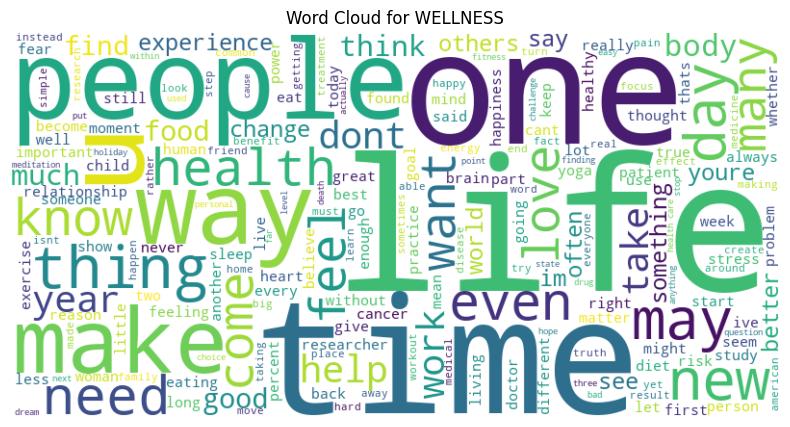

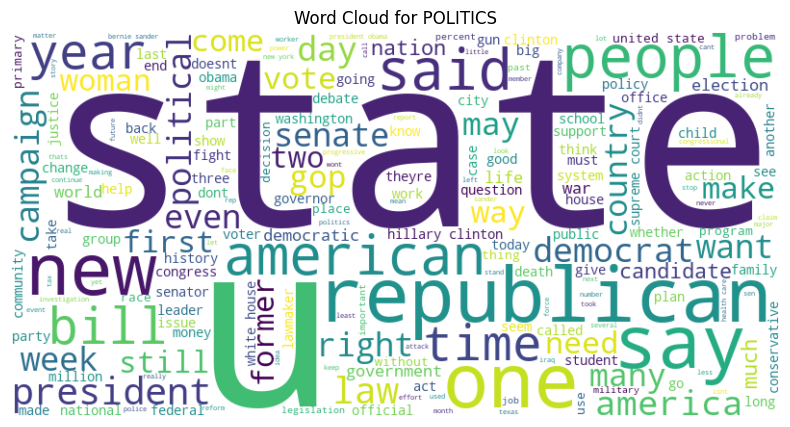

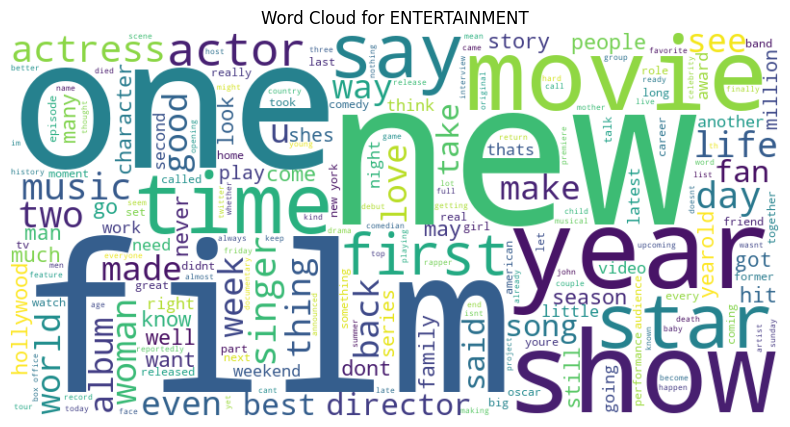

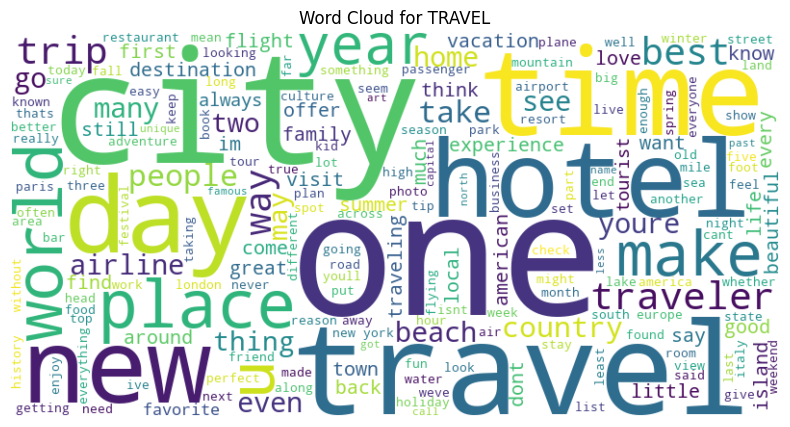

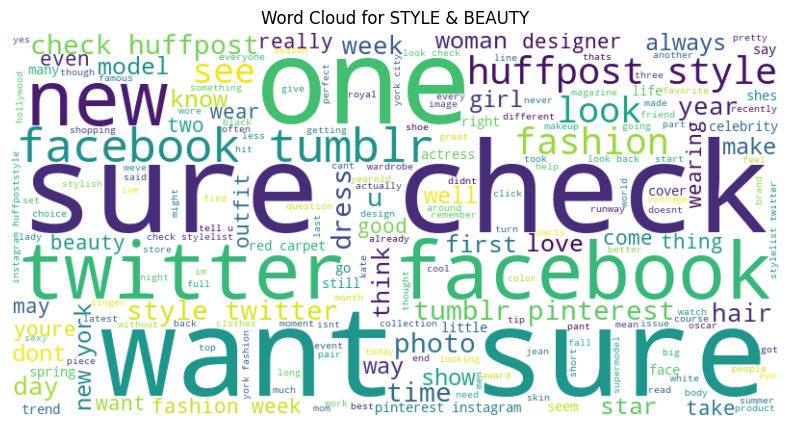

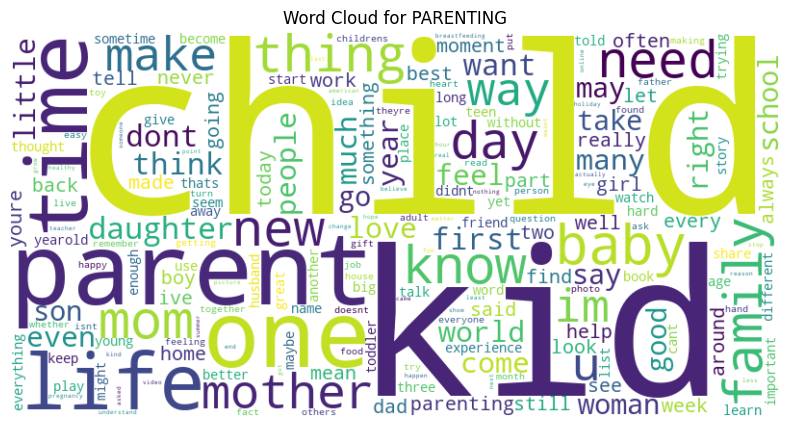

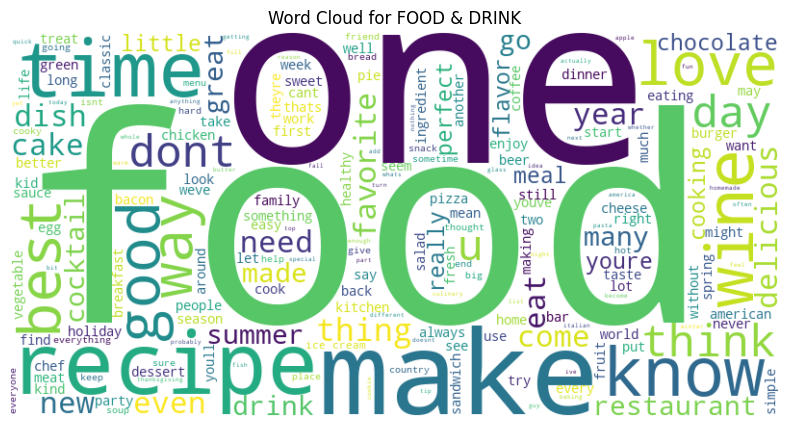

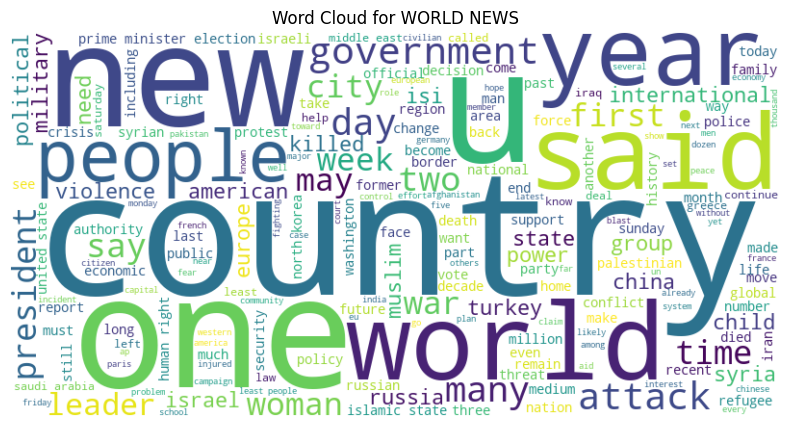

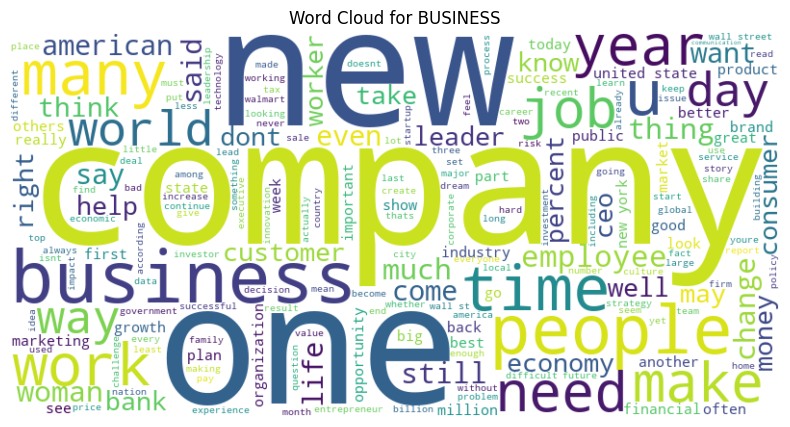

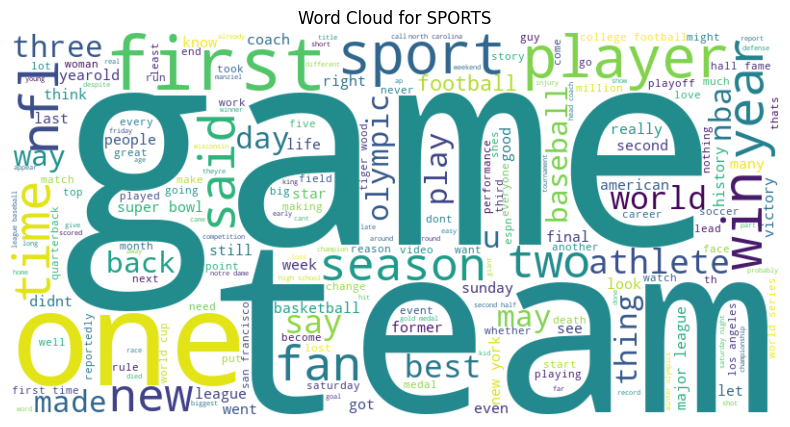

In [17]:
## Word clouds for insights on important features
for category in df['category'].unique():
    text = ' '.join(df[df['category'] == category]['processed_text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {category}')
    plt.axis('off')
    plt.show()

In [18]:
## Feature importance for Logistic Regression
if isinstance(best_model.named_steps['classifier'], LogisticRegression):
    coefficients = best_model.named_steps['classifier'].coef_[0]
    features = tfidf_vectorizer.get_feature_names_out()
    top_features = sorted(zip(coefficients, features), reverse=True)[:10]
    print("Top 10 Features Driving Classification:", top_features)

Top 10 Features Driving Classification: [(6.167968110009306, 'company'), (5.6359938525168465, 'business'), (4.431761733943145, 'employee'), (4.369951281667823, 'leadership'), (4.320347569298261, 'financial'), (4.119350474877194, 'economy'), (4.100520448687102, 'bank'), (3.9400207730703585, 'ceo'), (3.8576809873319426, 'entrepreneur'), (3.8333211144758805, 'marketing')]


### Video URL
https://drive.google.com/file/d/1CbPJotAIzzp_1NUWVIdc_bBsrFGk1x00/view?usp=sharing